In [2]:
import numpy as np
import pylab as plt
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(0)


/usr/lib/python3/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Construction

We construct a binary data set with $1000$ data points that belong to class

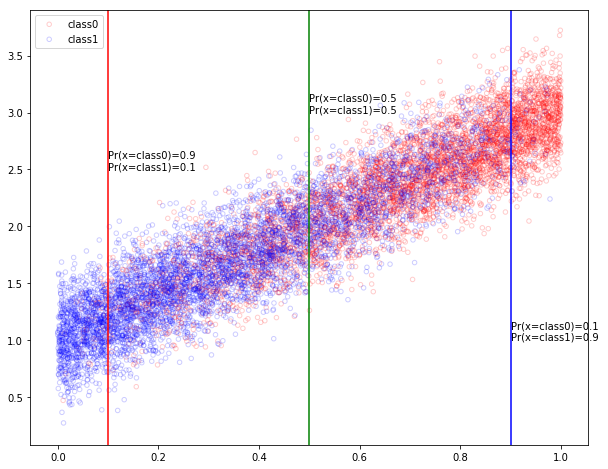

In [16]:
def f(x):
    return 2*x + 1

x=np.random.uniform(0,1,10000)


x0 = []
y0 = []

x1 = []
y1 = []

Y1=np.zeros(len(x))

X1=np.zeros((len(x),2))


for i in range(len(x)):

    
    if np.random.random() < x[i]:
        x0.append(x[i])
        y0.append( f(x[i]) + np.random.normal(0,0.25)  )

        
    else:
        x1.append(x[i])
        y1.append( f(x[i]) + np.random.normal(0,0.25) ) 
        
plt.figure(figsize=(10,8))
plt.scatter(x0,y0,s=20,facecolors='none',edgecolors='r',alpha=0.2,label='class0')
plt.scatter(x1,y1,s=20,facecolors='none',edgecolors='b',alpha=0.2,label='class1') # class 1
plt.axvline(0.1,color='red')
plt.axvline(0.5,color='green')
plt.axvline(0.9,color='blue')
plt.text(0.1,2.5,s='Pr(x=class0)=0.9 ' + '\n' + 'Pr(x=class1)=0.1 ' )
plt.text(0.5,3,s='Pr(x=class0)=0.5 ' + '\n' + 'Pr(x=class1)=0.5 ' )
plt.text(0.9,1,s='Pr(x=class0)=0.1 ' + '\n' + 'Pr(x=class1)=0.9 ' )
plt.legend()
plt.show()


## Rescaling, reshaping and splitting the data for use in the neural network in training and testting

In [3]:
Y1=np.zeros(len(x0))
Y2=np.ones(len(x1))

Y=np.concatenate((Y1, Y2), axis=0)

x=np.concatenate((x0, x1), axis=0)
y=np.concatenate((y0, y1), axis=0)

X=np.stack((x, y), axis=-1)


X = np.asarray(X)
Y = np.asarray(Y)

#X = scale(X)
X = X.astype(float)
Y = Y.astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25)

scaler = StandardScaler()
scaler.fit(X_train)


X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X.shape , Y.shape

((10000, 2), (10000,))

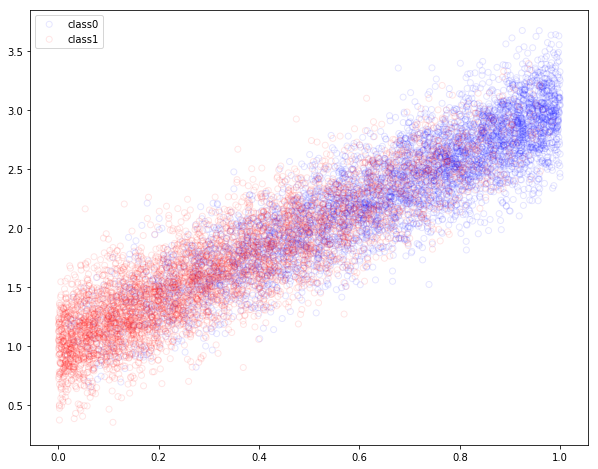

In [4]:

plt.figure(figsize=(10,8))
plt.scatter(X[Y==0, 0], X[Y==0, 1], facecolors='none',edgecolors='b',label='class0',alpha=0.1)
plt.scatter(X[Y==1, 0], X[Y==1, 1], facecolors='none',edgecolors='r',label='class1',alpha=0.1)
plt.legend()
plt.show()



## Building a neural betwork using a multi-layer perceptron from SKlearn

### - We look to observe the reliability curve of the neural network which will then be compare to the Bayesian neural network,

In [24]:
X_train

array([[-1.37393716, -1.37868348],
       [ 1.30172627,  0.83353475],
       [ 1.4203281 ,  1.33787306],
       ...,
       [ 0.13640505, -0.10811338],
       [-0.81269344, -0.96626191],
       [ 0.71667557,  0.30880873]])

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
%matplotlib inline

In [6]:
def reliability_curve(y_true, y_score, bins=10, normalize=False):
    """Compute reliability curve

    Reliability curves allow checking if the predicted probabilities of a
    binary classifier are well calibrated. This function returns two arrays
    which encode a mapping from predicted probability to empirical probability.
    For this, the predicted probabilities are partitioned into equally sized
    bins and the mean predicted probability and the mean empirical probabilties
    in the bins are computed. For perfectly calibrated predictions, both
    quantities whould be approximately equal (for sufficiently many test
    samples).

    Note: this implementation is restricted to binary classification.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        True binary labels (0 or 1).

    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive
        class or confidence values. If normalize is False, y_score must be in
        the interval [0, 1]

    bins : int, optional, default=10
        The number of bins into which the y_scores are partitioned.
        Note: n_samples should be considerably larger than bins such that
              there is sufficient data in each bin to get a reliable estimate
              of the reliability

    normalize : bool, optional, default=False
        Whether y_score needs to be normalized into the bin [0, 1]. If True,
        the smallest value in y_score is mapped onto 0 and the largest one
        onto 1.


    Returns
    -------
    y_score_bin_mean : array, shape = [bins]
        The mean predicted y_score in the respective bins.

    empirical_prob_pos : array, shape = [bins]
        The empirical probability (frequency) of the positive class (+1) in the
        respective bins.


    References
    ----------
    .. [1] `Predicting Good Probabilities with Supervised Learning
            <http://machinelearning.wustl.edu/mlpapers/paper_files/icml2005_Niculescu-MizilC05.pdf>`_

    """
    if normalize:  # Normalize scores into bin [0, 1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2

    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width / 2 < y_score,
                                 y_score <= threshold + bin_width / 2)
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos

In [7]:
bins=25

reliability_scores = {}
y_score = {}
clf = MLPClassifier(solver='adam',alpha=1e-5,hidden_layer_sizes=(5,5),random_state=1)

clf.fit(X_train,Y_train)
pred=clf.predict(X_test)

y_score['MLP classifier'] = clf.predict_proba(X_test)[:,1]
reliability_scores['MLP classifier']=\
reliability_curve(Y_test , y_score['MLP classifier'], bins=bins , normalize=False)

/usr/lib/python3/dist-packages/ipykernel/__main__.py:67: RuntimeWarning: Mean of empty slice.
/home/tumisang/.local/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3/dist-packages/ipykernel/__main__.py:68: RuntimeWarning: Mean of empty slice.


	Accuracy: 0.756
	Precision: 0.740
	Recall: 0.792
	F1: 0.765



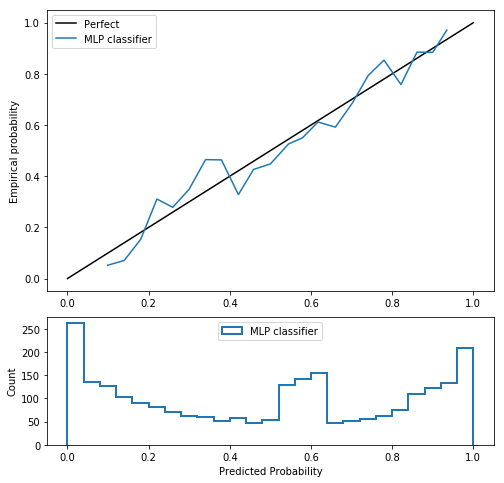

In [8]:
plt.figure(0, figsize=(8, 8))
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect") 
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    plt.plot(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan], label=method)
plt.ylabel("Empirical probability")
plt.legend(loc=0)

plt.subplot2grid((3, 1), (2, 0))
for method, y_score_ in y_score.items():
    y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
    plt.hist(y_score_, range=(0, 1), bins=bins, label=method,
             histtype="step", lw=2)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend(loc='upper center', ncol=2)


print("\tAccuracy: %1.3f"%clf.score(X_test, Y_test))
print("\tPrecision: %1.3f" % precision_score(Y_test, pred))
print("\tRecall: %1.3f" % recall_score(Y_test, pred))
print("\tF1: %1.3f\n" % f1_score(Y_test, pred))

## Now we make the plot where we compare our x vaules which by construction is our real probabilities of any point belonging to class 1 to the predicted probabilities


In [37]:
Pred_prob=clf.predict_proba(X_test)
X_true=scaler.inverse_transform(X_test, copy=None)

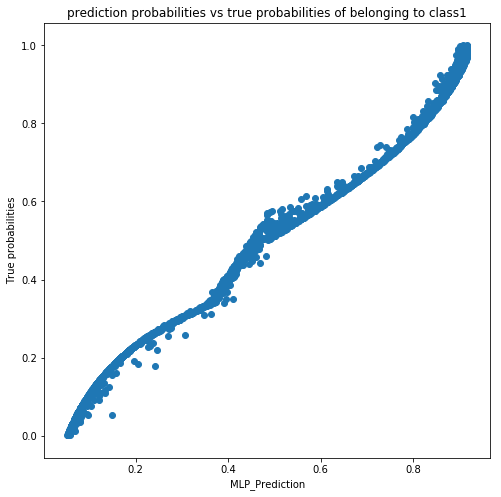

In [39]:
plt.figure(figsize=(8,8))
plt.title('prediction probabilities vs true probabilities of belonging to class1')
plt.scatter(Pred_prob[:,0],X_true[:,0])
plt.xlabel('MLP_Prediction')
plt.ylabel('True probabilities')
plt.show()